In [3]:
### Run this cell before continuing
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

# Introduction
Wine, one of the most popular beverages in the world, has been of mankind’s interest for thousands of years (Cuber, 2020). The winemaking process, at its core, involves fermentation using yeast, leading to the production of lactic acid and ethanol (Lonvaud-Funel, 1999). The degree of fermentation impacts sugar and alcohol levels, while sulphate levels are affected by the content of yeast. Cortez et al. performed a study on the relationship between the physicochemical factors of wine -  alcohol, sulphates, acidity etc. - and the quality of white *vinho verde* wine - evaluated on a scale of 1-10 by researchers and oenologists (2009).

In this project, we selected the white wine data as it contains a larger data set and higher precision (Cortez et al., 2009). We will attempt to determine if the quality of white wine is heavily impacted by alcohol and sulphate content, as suggested in Cortez et al.’s study. It is anticipated that these two components will have the strongest impact on the white wine, according to the previous study. These two components should allow us to create a classification model with at least 50% accuracy in order to predict future observations that might be added.

# Methods & Results

We use the White Wine Quality data available. In order to gain direct access to the dataset, we first download the file from the internet using a URL. We store this data as `white_wine` using `read_delim` with the `;` delimiter.

In [4]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

download.file(url, destfile = "winequality-white.csv")
white_wine <- read_delim("winequality-white.csv", delim = ";")
white_wine

Rows: 4898 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.5,0.24,0.19,1.2,0.041,30,111,0.99254,2.99,0.46,9.4,6
5.5,0.29,0.30,1.1,0.022,20,110,0.98869,3.34,0.38,12.8,7
6.0,0.21,0.38,0.8,0.020,22,98,0.98941,3.26,0.32,11.8,6


We refactor  `quality` using `as_factor` in order to use it for classification.

In [5]:
white_wine <- white_wine |>
    mutate(quality = as_factor(quality))

View(white_wine)

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.5,0.24,0.19,1.2,0.041,30,111,0.99254,2.99,0.46,9.4,6
5.5,0.29,0.30,1.1,0.022,20,110,0.98869,3.34,0.38,12.8,7
6.0,0.21,0.38,0.8,0.020,22,98,0.98941,3.26,0.32,11.8,6


We create a scatterplot visualization of `sulphates` versus `alcohol`, with`quality` as the argument for `color`.

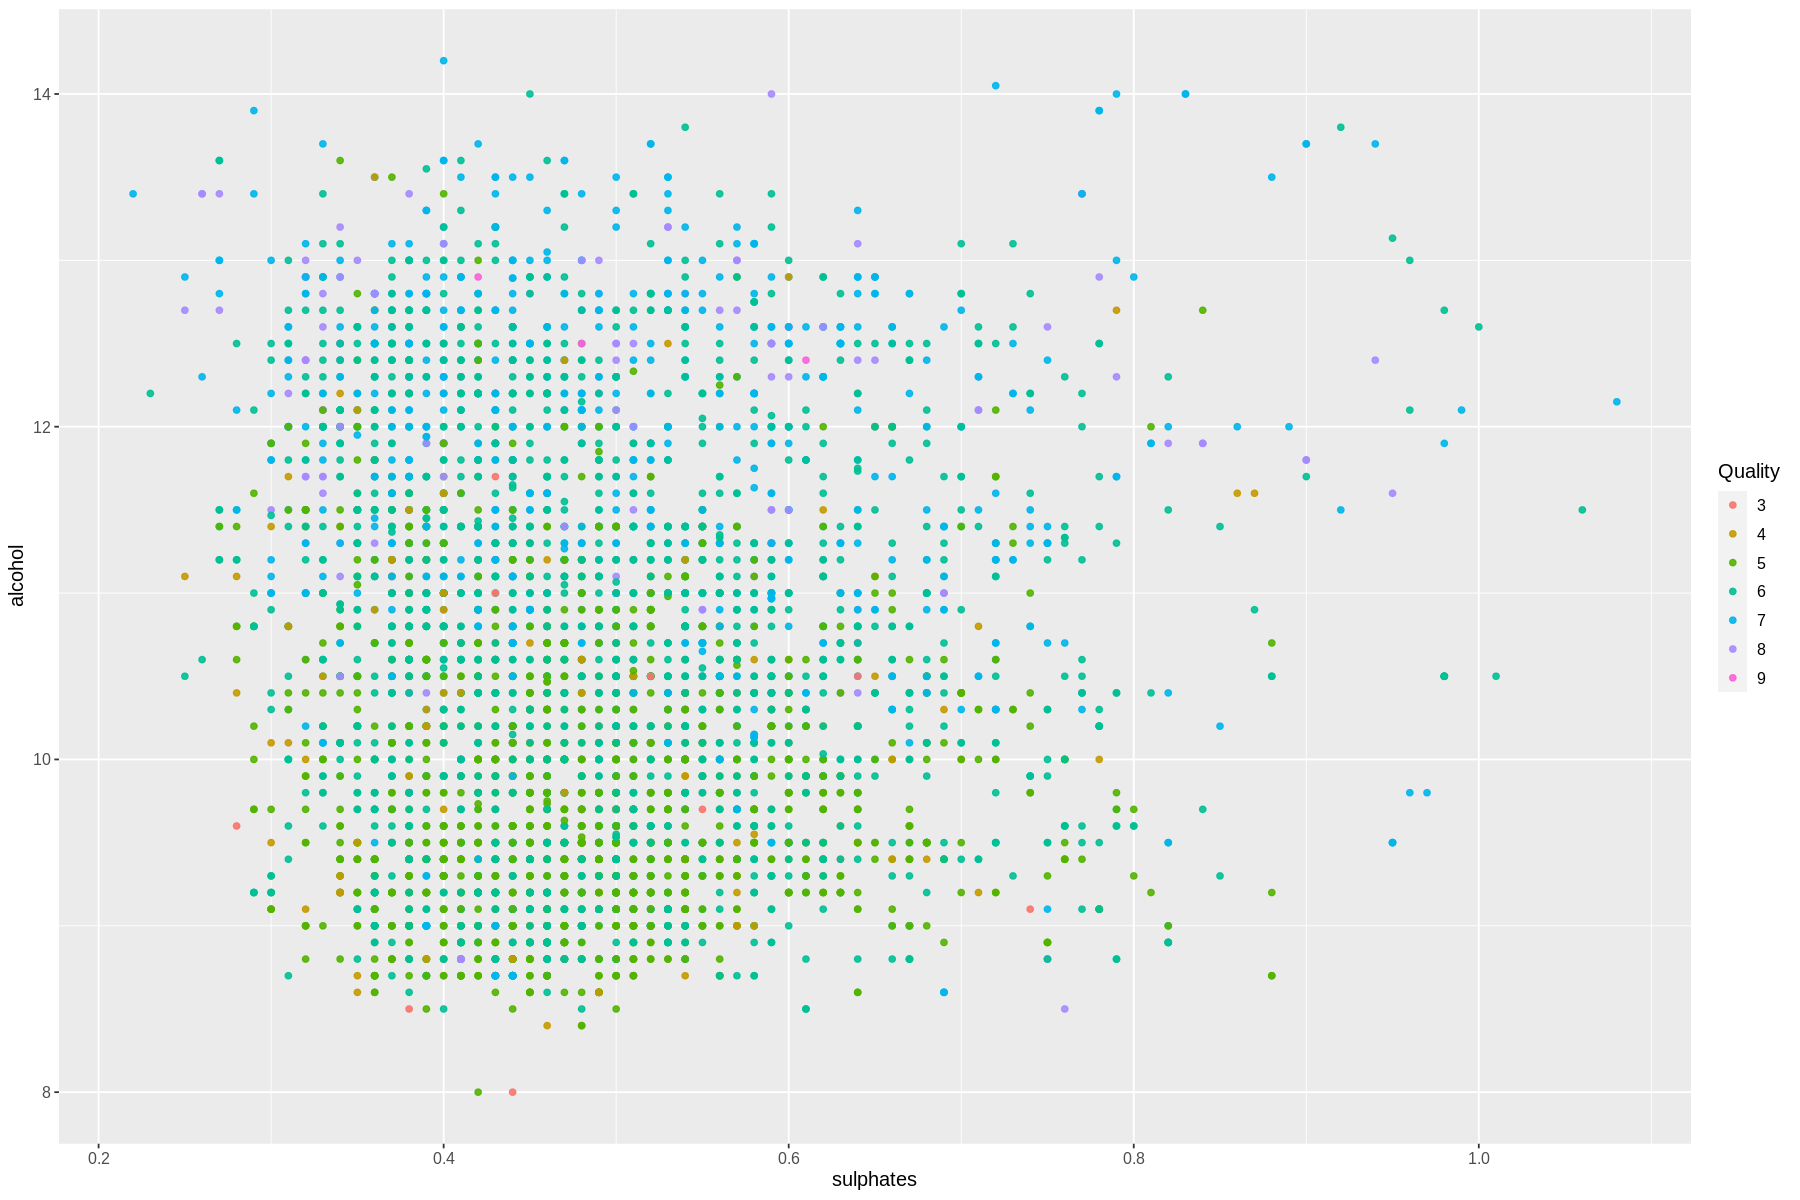

In [6]:
options(repr.plot.width=15, repr.plot.height=10)
white_wine_plot <- white_wine |>
  ggplot(aes(x = sulphates, y = alcohol, color = quality)) +
  geom_point(alpha = 0.9) +
  labs(color = "Quality") + 
  theme(text = element_text(size = 12))

white_wine_plot

As seen in the graph, there is a larger presence of green and blue dots than there are red, orange, purple or pink dots. We can infer that there is a larger presence of medium quality wine (in the 5 to 7 range) while the high  and low values are not as prevalent.

Next, we split the data into Training and Testing Sets.

We use the `initial_split` function to split `white_wine`, with 75% of the data falling into `ww_train` and `quality` as the argument for `strata`.

By splitting up this data into `ww_train` and `ww_test`, we can choose to only show the training set when building the classifier. We will then evaluate the accuracy of the classifier to predict the labels (which we know) in the test set.

In [7]:
set.seed(1234)

ww_split <- initial_split(white_wine, prop = 0.75, strata = quality)
ww_train <- training(ww_split)
ww_test <- testing(ww_split)

glimpse(ww_train)

Rows: 3,673
Columns: 12
$ `fixed acidity`        <dbl> 8.6, 8.3, 6.5, 6.8, 5.8, 7.3, 6.2, 6.9, 7.0, 6.…
$ `volatile acidity`     <dbl> 0.230, 0.420, 0.310, 0.260, 0.270, 0.240, 0.460…
$ `citric acid`          <dbl> 0.40, 0.62, 0.14, 0.42, 0.20, 0.39, 0.25, 0.35,…
$ `residual sugar`       <dbl> 4.20, 19.25, 7.50, 1.70, 14.95, 17.95, 4.40, 5.…
$ chlorides              <dbl> 0.035, 0.040, 0.044, 0.049, 0.044, 0.057, 0.066…
$ `free sulfur dioxide`  <dbl> 17.0, 41.0, 34.0, 41.0, 22.0, 45.0, 62.0, 32.0,…
$ `total sulfur dioxide` <dbl> 109.0, 172.0, 133.0, 122.0, 179.0, 149.0, 207.0…
$ density                <dbl> 0.9947, 1.0002, 0.9955, 0.9930, 0.9962, 0.9999,…
$ pH                     <dbl> 3.14, 2.98, 3.22, 3.47, 3.37, 3.21, 3.25, 3.36,…
$ sulphates              <dbl> 0.53, 0.67, 0.50, 0.48, 0.37, 0.36, 0.52, 0.48,…
$ alcohol                <dbl> 9.7, 9.7, 9.5, 10.5, 10.2, 8.6, 9.8, 9.8, 10.5,…
$ quality                <fct> 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5,…


We use `group_by` and `summarize` functions to find the percentage of each measure of quality in `ww_train`. There are no values for 1, 2 or 10 and so the table is only from 3-9.

In [8]:
ww_proportions <- ww_train |>
                  group_by(quality) |>
                  summarize(n = n()) |>
                  mutate(percent = 100*n/nrow(ww_train))
ww_proportions

quality,n,percent
<fct>,<int>,<dbl>
3,14,0.3811598
4,121,3.2943098
5,1091,29.7032399
⋮,⋮,⋮
7,665,18.1050912
8,129,3.5121154
9,3,0.0816771


The values 3 and 9 represent a minimal amount, while 4 and 8 have a slightly higher percentage. 5, 6 and 7 hold the vast majority of shares, indicating that our class proportions were roughly preserved when the data was split.

The creation of the standardization preprocessor using only the `ww_train` data ensures that the test data does not influence any aspect of our training model and that our comparison at the end is true to the actual predictive methods. Once it is created, we can apply it to the training and testing datasets separately. This is done using `recipe`, where `all_predictors()` is scaled and centered.

In [9]:
set.seed(1234)

ww_recipe <- recipe(quality ~ sulphates + alcohol, data = ww_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

After the split, we can create our K-nearest neighbors classifier with only the training set using the technique we learned in the previous chapter. For now, we choose K to be 3, with `sulphates` and `alcohol` as the predictors. We create a model specification and combine it with `ww_recipe` using `workflow()` and finally, we use `fit` with `ww_train` to build the classifier. 

In [10]:
set.seed(1234)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(ww_recipe) |>
  add_model(knn_spec) |>
  fit(data = ww_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4222706
Best kernel: rectangular
Best k: 3

Now that we have a K-nearest neighbors classifier object, we use it to predict class labels for our test set. We use `bind_cols` to add the column of predictions to the original test data, stored as `ww_test_predictions`. `quality` contains the true value of the quality while `.pred_class` contains the predicted quality using the classifier.

In [11]:
set.seed(1234)

ww_test_predictions <- predict(knn_fit, ww_test) |>
  bind_cols(ww_test)

ww_test_predictions

.pred_class,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5,6.3,0.30,0.34,1.60,0.049,14,132,0.9940,3.30,0.49,9.5,6
6,8.1,0.27,0.41,1.45,0.033,11,63,0.9908,2.99,0.56,12.0,5
6,7.9,0.18,0.37,1.20,0.040,16,75,0.9920,3.18,0.63,10.8,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,6.6,0.34,0.40,8.1,0.046,68,170,0.99494,3.15,0.50,9.55,6
7,6.2,0.41,0.22,1.9,0.023,5,56,0.98928,3.04,0.79,13.00,7
7,6.5,0.23,0.38,1.3,0.032,29,112,0.99298,3.29,0.54,9.70,5


Finally, we assess our classifier’s accuracy using the `metrics` function from `tidymodels` to get the statistics about the quality of our model, specifying `truth` and `estimate` arguments.

In [12]:
set.seed(1234)

ww_test_predictions |>
  metrics(truth = quality, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4693878


Looking at the value of `.estimate` shows that the estimated accuracy of the classifier on the test data was 46.93%.

We also look at the confusion matrix for the classifier.

In [13]:
set.seed(1234)

confusion <- ww_test_predictions |>
             conf_mat(truth = quality, estimate = .pred_class)
confusion

          Truth
Prediction   3   4   5   6   7   8   9
         3   0   0   0   1   1   0   0
         4   0   1  16  17   2   0   0
         5   1  15 230 203  40   8   1
         6   5  21  96 264  94  14   1
         7   0   4  15  53  66  10   0
         8   0   1   9  10  12  14   0
         9   0   0   0   0   0   0   0

The confusion matrix shows 575 observations were correctly predicted while it incorrectly classified 650.

In [14]:
ww_proportions

quality,n,percent
<fct>,<int>,<dbl>
3,14,0.3811598
4,121,3.2943098
5,1091,29.7032399
⋮,⋮,⋮
7,665,18.1050912
8,129,3.5121154
9,3,0.0816771


Since the 5,6 and 7 quality values represent the majority of the training data, the majority classifier would always predict that a new observation would fall into one of these values. The estimated accuracy of the majority classifier is usually fairly close to the majority class proportion in the training data. In this case, we would suspect that the majority classifier will have an accuracy of around 44%.

With the K-nearest neighbors classifier that we built showing an accuracy of ~47%, we can conclude that although the accuracy for the majority classifier was improved, the critical analysis suggests that this classifier may not have appropriate performance for the application.

#### Determining Best K

In order to determine the best K for the predictor, we perform a 10-fold cross-validation using `vfold_cv` with `quality` as the `strata` argument. 

We create a K-nearest neighbour model specification without a particular value and instead use `tune()`, allowing  us to determine the best K. 

We create a `workflow()` analysis to combine `ww_recipe` and `knn_tune` that we just created. We use `tune_grid` to fit the model for each value in the range - set to 15 - instead of using `fit` as before. 

Using the `ww_vfold` model created, we can input it into `resamples` before using `collect_metrics()` to find the  information used to determine the best values of K. We use `filter` to show only the rows pertaining to `accuracy`.

In [15]:
set.seed(123)

ww_vfold <- vfold_cv(ww_train, v = 10, strata = quality)
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

##(5)##
ww_results <- workflow() |>
  add_recipe(ww_recipe) |>
  add_model(knn_tune) |>
  tune_grid(resamples = ww_vfold, grid = 15) |>
  collect_metrics() |>
  filter(.metric == "accuracy")
ww_results

! Fold01: internal:
  No observations were detected in `truth` for level(s): '3'
  Computation will proceed by ignoring those levels.

! Fold02: internal:
  No observations were detected in `truth` for level(s): '3', '9'
  Computation will proceed by ignoring those levels.

! Fold04: internal:
  No observations were detected in `truth` for level(s): '9'
  Computation will proceed by ignoring those levels.

! Fold05: internal:
  No observations were detected in `truth` for level(s): '9'
  Computation will proceed by ignoring those levels.

! Fold06: internal:
  No observations were detected in `truth` for level(s): '9'
  Computation will proceed by ignoring those levels.

! Fold07: internal:
  No observations were detected in `truth` for level(s): '9'
  Computation will proceed by ignoring those levels.

! Fold08: internal:
  No observations were detected in `truth` for level(s): '9'
  Computation will proceed by ignoring those levels.

! Fold09: internal:
  No observations were detecte

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4685804,10,0.005690782,Preprocessor1_Model01
2,accuracy,multiclass,0.4745728,10,0.006556602,Preprocessor1_Model02
3,accuracy,multiclass,0.4816187,10,0.004763835,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,accuracy,multiclass,0.4892867,10,0.007150133,Preprocessor1_Model12
14,accuracy,multiclass,0.4854883,10,0.009721631,Preprocessor1_Model13
15,accuracy,multiclass,0.4860177,10,0.008365452,Preprocessor1_Model14


We create a line plot using `ww_results` with `neighbors` on the x-axis and `mean` on the y-axis and see that the optimal K is 12. We use the `geom_vline` function to see the highest point on the graph.

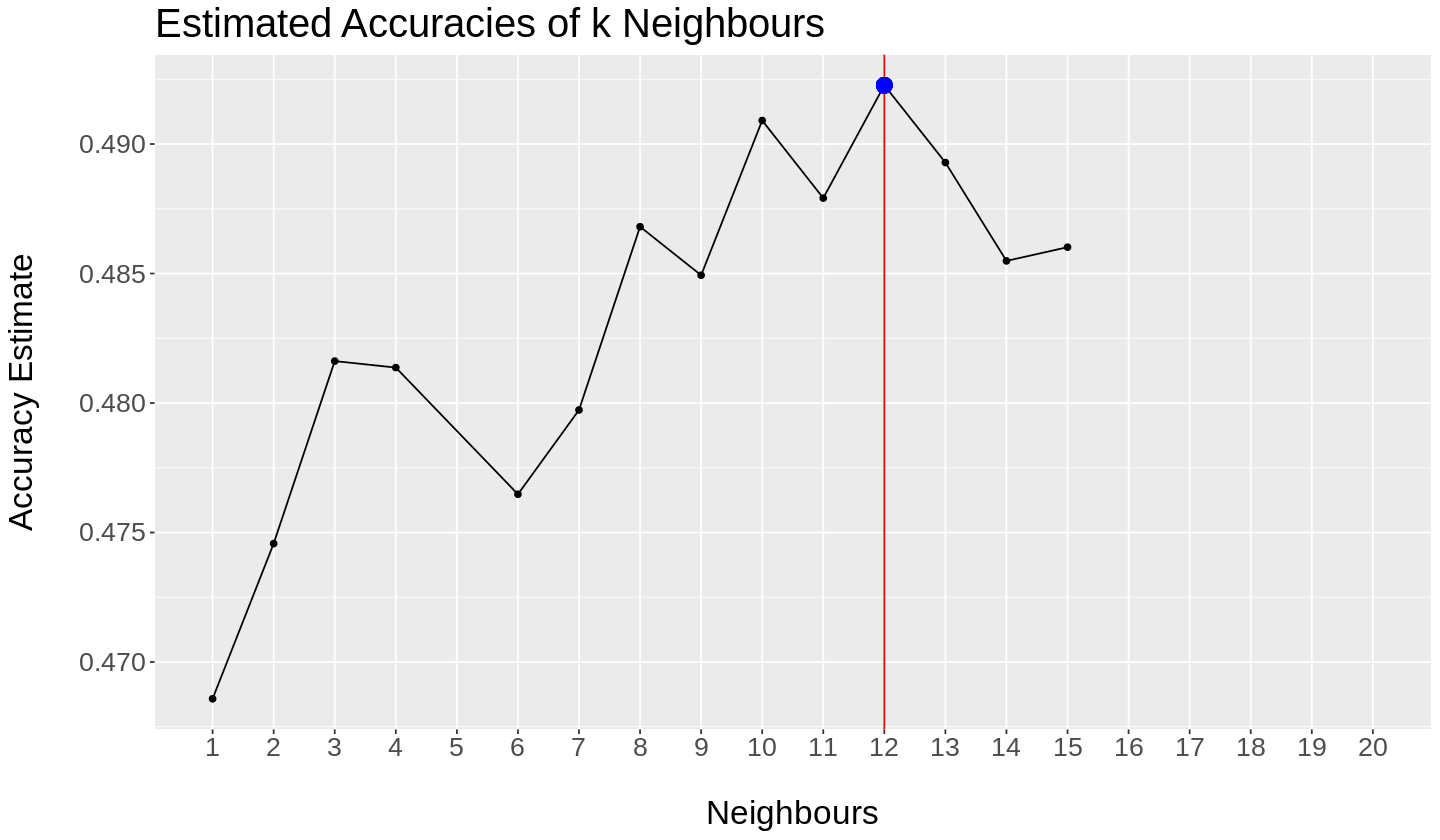

In [16]:
options(repr.plot.width = 12, repr.plot.height = 7)

ky <- ww_results |>
    filter(neighbors == 12) |>
    select(mean) |>
    pull()

cross_val_plot <- ww_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = 12, colour = "red") +
    geom_point(aes(x = 12, y = ky), size = 4, colour = "blue") +
    labs(x = "\nNeighbours",
         y = "Accuracy Estimate\n",
         title = "Estimated Accuracies of k Neighbours") +
    scale_x_continuous(limits = c(1, 20),
                       breaks = seq(1, 20),
                       minor_breaks = seq(1, 20, 1)) +
    theme(text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0))

cross_val_plot

We create `knn_best_spec`, using the accuracy estimate found in the previous step. With this, we create another `workflow()` analysis, combining it with `ww_recipe`. We `fit` this with `ww_train` to use it in `predict`, giving us possible predictions for our test dataset.

In [17]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) |>
  set_engine("kknn") |>
  set_mode("classification")

ww_fit <- workflow() |>
  add_recipe(ww_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = ww_train)

##(8)##
# Get the prediction column
ww_predictions <- predict(ww_fit, ww_test) |> 
    bind_cols(ww_test)

ww_predictions

.pred_class,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5,6.3,0.30,0.34,1.60,0.049,14,132,0.9940,3.30,0.49,9.5,6
6,8.1,0.27,0.41,1.45,0.033,11,63,0.9908,2.99,0.56,12.0,5
6,7.9,0.18,0.37,1.20,0.040,16,75,0.9920,3.18,0.63,10.8,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,6.6,0.34,0.40,8.1,0.046,68,170,0.99494,3.15,0.50,9.55,6
6,6.2,0.41,0.22,1.9,0.023,5,56,0.98928,3.04,0.79,13.00,7
6,6.5,0.23,0.38,1.3,0.032,29,112,0.99298,3.29,0.54,9.70,5


We find the accuracy of the classifier just as before.

In [18]:
# Compare the accuracy of predictions to the true values in the test set
ww_acc <- ww_predictions |> 
    metrics(truth = quality, estimate = .pred_class) |>
    select(.metric, .estimate) |> 
    head(1)
ww_acc

.metric,.estimate
<chr>,<dbl>
accuracy,0.4669388


We find that `.estimate` is slightly lower than the one found earlier so the best value of K is not in fact 12 and the number that we used earlier is better.

We again create a confusion matrix.

In [19]:
# Compare the predictions to the true values in a confusion matrix
ww_cm <- ww_predictions |> 
    conf_mat(truth = quality, estimate = .pred_class)
ww_cm

          Truth
Prediction   3   4   5   6   7   8   9
         3   0   0   0   0   0   0   0
         4   0   0   0   2   0   0   0
         5   2  17 178 151  28   4   0
         6   4  21 161 333 127  26   1
         7   0   4  23  61  59  14   1
         8   0   0   4   1   1   2   0
         9   0   0   0   0   0   0   0

We find that 572 observations were correctly placed while 653 observations were mislabeled.

# Discussion
Portugal is one of the leading countries in wine production in the world (Chepkemoi, 2023). Exports of its *vinho verde* wine has increased by 36% from 1997 to 2007. Physicochemical and sensory analyses are essential in the development and improvement of wine quality, in order to compete in the global wine industry.

### Expected vs Actual Outcome
As stated in the introduction, the expected outcome of this project was to prove the study by Cortez et al., proving that sulphates and alcohol content had the most impact in determining the quality of white wine. We went on to show this through the generation of our classification model, expecting our classification accuracy to be at the very least higher than 50%.

Our results were not as expected: our assumption that alcohol and sulphates were the two most important physicochemical properties in determining quality of wine proved to be poor using our classification model. Our best classification accuracy - 46.6% - was lower than the 50% that we had hoped for in our hypothesis. Although the scatter plot appeared to be "grouped up" it was far too spread out and did not give a clear indication that there was variation in wine quality based on these two parameters or perhaps that they were not as important as was stated in the Cortez et al. study.

There is a strong possibility that the potential errors from the analysis could have risen from a lack of diversity in the quality of wine, having not enough values of low quality and high quality wine. As we saw earlier, the average quality of wine was in the 5-7 region that made up ~92.7% of the total data. Having this low variability did not allow us to ensure that a comprehensive and accurate analysis of white wine quality could be done. 

### Impact of Findings
First and foremost, it must be acknowledged that the properties selected according to the Cortez et al. study were not necessarily the best ones and that there might be others that would be better in predicting the quality of wine. This is not to say that they are bad, seeing as though the model created from these two variables can essentially predict that 46% of the time, the wine quality will be a 6 since it takes up the largest percentage of wine qualities. As we previously stated, having a low variability makes it hard for the model - or likely any model - to be able to reasonably predict the quality of *vinho verde* wine every time. 

There is however a lot of upside in the study of this dataset. Seeing as though the importance of wine quality has rapidly increased due to consumer demand following the pandemic, this model could aid companies in the development of technology that would allow for an increased production of high-quality wine, in order to satisfy consumers' needs. In particular, finding the key variables in the dataset would allow such companies to do so. And although it may not seem like an increased production of wine would necessarily be a good thing, research has shown that drinking one or two glasses of wine increases antioxidants called polyphenols, which may help protect the lining of blood vessels in the heart, allowing for cardiovascular protection (Blanch and Ros, 2012).

The results of the study are important for the wine industry, as they provide an objective way to evaluate wine quality that can be integrated into a decision support system. This could benefit oenologists in their work and improve the training of oenology students. The relative importance of different inputs also provides insights into how to improve wine quality by manipulating specific physicochemical properties. Finally, the predictive models could be used for target marketing, allowing wineries to target their products to specific consumer preferences.

### Future Questions
This study could lead to many important questions regarding the dataset and also the wine industry as a whole. 

The dataset should be reconsidered and revisited through the study of different variables though, it must be kept in mind that the dataset will have issues rooted in the lack of variability regardless of the variables chosen. An important question that might stem from this is whether or not a different dataset entirely would show similar results - lack of variability, slightly above "standard average" mean etc. - or if it is this dataset in particular that displays these qualities. This question can also be used by the wine industry as a whole to see whether or not the understanding of different physicochemical properties can truly allow them to understand its effect on the quality of wine. With this, it would allow for the increased satisfaction of consumers.

As previously stated, research showing that wine might in fact aid in maintaining good health must also be brought into question: Could government agencies and policymakers use the dataset to inform decisions about regulations and policies related to the wine industry?

# References
Blanch, Gemma, et al. “Effects of Red Wine Polyphenols and Alcohol on Glucose Metabolism and the Lipid Profile: A         Randomized Clinical Trial.” Clinical Nutrition (Edinburgh, Scotland), U.S. National Library of Medicine,
        https://pubmed.ncbi.nlm.nih.gov/22999066/. 
        
Chepkemoi, Joyce Chepkemoi. “Top 10 Wine Producing Countries in the World 2021.” Wine Producing Countries 2023,           https://worldpopulationreview.com/country-rankings/wine-producing-countries. 

Cortez, Paulo; Cerdeira, A.; Almeida, F.; Matos, T.; Reis, J. Modeling Wine Preferences by Data Mining from               Physicochemical Properties. Decision Support Systems 2009, 47 (4), 547–553.

Cuber, James. “History of Winemaking.” ArcGIS StoryMaps, Esri, 2 Dec. 2020,
        https://storymaps.arcgis.com/stories/c5a01856223745d19ee5a2f640624b83.
        
Lonvaud-Funel, A. Lactic Acid Bacteria in the Quality Improvement and Depreciation of Wine. Lactic Acid Bacteria:         Genetics, Metabolism and Applications 1999, 317–331.